# Investigating Ontario's Covid-19 Spread
> Insights into the Covid-19 spread in Ontario, Canada.

- toc: true 
- badges: true
- comments: true
- categories: [jupyter]
- image: images/test.png

In [34]:
#hide

"""

 TO DO LIST:

 - percent posititvity in hotzones
 - hotzone regional analysis
 - deaths vs ltc deaths
 - add death/survival rate to number plate

- mini overview of some basic stats (dashboard style):
    -death rate, recovery rate (Done)
    - number of new cases per region (Done)


- percent positivity; use the 3 methods outlined by the CDC (Done)
- break this down overall, and by month/quarter and evaluate
- false positive data
- negative tests relative to population
- recovery rate (done)
- death rate (Done)
- top 5 regions time series

"""

'\n\n TO DO LIST:\n\n - percent posititvity in hotzones\n - hotzone regional analysis\n - deaths vs ltc deaths\n - add death/survival rate to number plate\n\n- mini overview of some basic stats (dashboard style):\n    -death rate, recovery rate (Done)\n    - number of new cases per region (Done)\n\n\n- percent positivity; use the 3 methods outlined by the CDC (Done)\n- break this down overall, and by month/quarter and evaluate\n- false positive data\n- negative tests relative to population\n- recovery rate (done)\n- death rate (Done)\n- top 5 regions time series\n\n'

In [35]:
#hide
#!pip install -q geopandas
#!pip install sweetviz

In [36]:
#hide
# import urllib, json, os, time
# import dateutil.parser
# import re

import pandas as pd
import numpy as np

import plotly.graph_objects as go
import plotly.express as px
import altair as alt

from IPython.display import HTML, display
import pytz

import ipywidgets as widgets

from datetime import datetime, timedelta, timezone

# import geopandas as gpd
# import sweetviz as sv

print('Libraries successfully imported.')

Libraries successfully imported.


In [37]:
#hide
#%%time

url = 'https://data.ontario.ca/dataset/f4112442-bdc8-45d2-be3c-12efae72fb27/resource/455fd63b-603d-4608-8216-7d8647f43350/download/conposcovidloc.csv'
url_2 = 'https://data.ontario.ca/dataset/f4f86e54-872d-43f8-8a86-3892fd3cb5e6/resource/ed270bb8-340b-41f9-a7c6-e8ef587e6d11/download/covidtesting.csv'
url_3 = 'https://data.ontario.ca/dataset/f4f86e54-872d-43f8-8a86-3892fd3cb5e6/resource/8a88fe6d-d8fb-41a3-9d04-f0550a44999f/download/daily_change_in_cases_by_phu.csv'

#geo = gpd.read_file('https://data.ontario.ca/dataset/f4112442-bdc8-45d2-be3c-12efae72fb27/resource/4f39b02b-47fe-4e66-95b6-e6da879c6910/download/conposcovidloc.geojson') 

src_conpos = pd.read_csv(url, index_col=0, parse_dates=['Accurate_Episode_Date', 'Case_Reported_Date', 'Test_Reported_Date', 'Specimen_Date']).reset_index()
src_testing = pd.read_csv(url_2, index_col=0, parse_dates=['Reported Date']).reset_index()
src_daily = pd.read_csv(url_3, index_col=0, parse_dates=['Date']).reset_index()

# duplicate entry for December 5th, 2020 causing error
src_testing.drop_duplicates(inplace=True)

refreshtime = datetime.now()
cached=False

print('Source files successfully loaded.')

Source files successfully loaded.


In [38]:
#hide
last_date = src_testing['Reported Date'].max()
init_date = src_conpos['Accurate_Episode_Date'].min()
display(HTML("Ontario data set last updated on: " + last_date.strftime("%x")))

In [39]:
#hide
# src_testing[src_testing['Confirmed Negative'] > 0].tail() # no confirmed negatives after March 29th 2020

# testing_latest = src_testing[src_testing['Reported Date'] == src_testing['Reported Date'].max()]

# display(HTML("<div style = 'background-color: #504e4e; padding: 30px; text-align: center'>" +
#              "<span style='color: #fff; font-size:23px;'> Confirmed: "  + str('{:,.0f}'.format(int(testing_latest['Total Cases']))) +"</span>" +
#              "<span style='color: lightgreen; font-size:23px; margin-left:20px;'> Resolved: " + str('{:,.0f}'.format(int(testing_latest['Resolved']))) + "</span>" +
#              "<span style='color: orange; font-size:23px; margin-left:20px;'> Active: " + str('{:,.0f}'.format(int(testing_latest['Confirmed Positive']))) + "</span>" +
#              "<span style='color: red; font-size:23px;margin-left:20px;'> Deaths: " + str('{:,.0f}'.format(int(testing_latest['Deaths']))) + "</span>"+
#              "<br> <span style='color: #fff; font-size:11px;'> Ontario data last updated: "  + str(testing_latest['Reported Date'].max().strftime('%Y-%m-%d')) +"</span>" +
#              "</div>" 
#              )
#        )

In [40]:
#hide_input
src_testing[src_testing['Confirmed Negative'] > 0].tail() # no confirmed negatives after March 29th 2020

testing_latest = src_testing[src_testing['Reported Date'] == src_testing['Reported Date'].max()]

# get the previous day results
testing_delta1 = src_testing[src_testing['Reported Date'] == src_testing['Reported Date'].max() - timedelta(days=1)]

# get the daily percentage +/-
dailypct = src_testing.join(src_testing[['Total Cases', 'Resolved', 'Confirmed Positive', 'Deaths']].pct_change().add_suffix('_pct'))

dailypct = dailypct[dailypct['Reported Date'] == dailypct['Reported Date'].max()]

# apply a percentage format; conventional formatting method throws an error
def percentage_delta(raw):
  # pctfmt = raw.map('{:+.2%}'.format)
  # split = str(pctfmt).split()
  formatted_pct = str(raw.map('{:+.2%}'.format)).split()[1]
  return formatted_pct

# original background colour code: #504e4e, secondary: #585858

display(HTML(
    
    "<div id='number-plate' style = 'background-color: #ececec; padding: 30px; text-align: center; marginTop: 1%; marginBottom: 1%;'>" +

    "<p style='color: black; font-size: 32px'> Ontario Covid-19 Cases to Date</p>"
    
    "<div id='confirmed' style = 'display: inline-block'> <span style='color: black; font-size: 23px;'> Confirmed: " +
    str('{:,.0f}'.format(int(testing_latest['Total Cases']))) + "</span>" + 
    "<br> <span style='color: black; font-size:15px; '> " + 
    str('{0:+,d}'.format(int(testing_latest['Total Cases']) - (int(testing_delta1['Total Cases'])))) +
    ' (' + percentage_delta(dailypct['Total Cases_pct']) + ')' +
    "</span>" + 
    "</div>" +

    "<div id='resolved' style = 'display: inline-block'> <span style='color: #228b22; font-size: 23px; margin-left: 20px;'> Resolved: " + 
    str('{:,.0f}'.format(int(testing_latest['Resolved']))) + "</span>" + 
    "<br> <span style='color: black; font-size:15px; '>" + 
    str('{0:+,d}'.format(int(testing_latest['Resolved']) - (int(testing_delta1['Resolved'])))) +
    ' (' + percentage_delta(dailypct['Resolved_pct']) + ')' +
    "</span>" + 
    "</div>" +

    "<div id='active' style = 'display: inline-block'> <span style='color: orange; font-size: 23px; margin-left: 20px;'> Active: " + 
    str('{:,.0f}'.format(int(testing_latest['Confirmed Positive']))) +"</span>" + 
    "<br> <span style='color: black; font-size:15px; '>" + 
    str('{0:+,d}'.format(int(testing_latest['Confirmed Positive']) - (int(testing_delta1['Confirmed Positive'])))) +
    ' (' + percentage_delta(dailypct['Confirmed Positive_pct']) + ')' +
    "</span>" + 
    "</div>" +

    "<div id='deaths' style = 'display: inline-block'> <span style='color: red; font-size: 23px; margin-left: 20px;'> Deaths: " + 
    str('{:,.0f}'.format(int(testing_latest['Deaths']))) + "</span>" + 
    "<br> <span style='color: black; font-size:15px; '>" + 
    str('{0:+,d}'.format(int(testing_latest['Deaths']) - (int(testing_delta1['Deaths'])))) +
    ' (' + percentage_delta(dailypct['Deaths_pct']) + ')' +
    "</span>" + 
    "</div>" +

    "<br><div id='rates' style = 'display: block; marginTop: 1%;'> " +

    "<div id='deathrate' style = 'display: inline-block'> <span style='color: black;'> Current Death Rate: " +
    "</span>" +
    "<span style = 'color: red'>" +
    str((testing_latest['Deaths'] / testing_latest['Total Cases']).map('{:.2%}'.format)).split()[1] + 
    "</span>" +
    "</div>" +

    "<div id='survivalrate' style = 'display:inline-block'> <span style='color: black; margin-left: 20px;'> Current Survival Rate: " + 
    "</span>" +
    "<span style = 'color: #228b22'>" +
    str(((testing_latest['Total Cases'] - testing_latest['Deaths']) / testing_latest['Total Cases']).map('{:.2%}'.format)).split()[1] + 
    "</span>" +
    "</div>" +

    "</div>" +

    "<span style='color: black; font-size: 11px;'> Ontario data last updated: " + 
    str(testing_latest['Reported Date'].max().strftime('%Y-%m-%d')) + ", Refreshed on: " + datetime.now(pytz.timezone('America/New_York') ).strftime("%Y-%m-%d at %H:%M") +
    "</span>" +

    "</div>"
    
    ))

In [41]:
#hide_input
# display(HTML("<div style = 'background-color: #504e4e; padding: 30px; '>" +
#              "<span style='color: #fff; font-size:30px; margin-left:20px;'> Confirmed: " + str('{:,.0f}'.format(int(testing_latest['Total Cases']))) +"</span>" +
#              "<br> <span style='color: lightgreen; font-size:30px; margin-left:20px;'> Resolved: " + str('{:,.0f}'.format(int(testing_latest['Resolved']))) + "</span>"+
#              "<br> <span style='color: orange; font-size:30px; margin-left:20px;'> Active: " + str('{:,.0f}'.format(int(testing_latest['Confirmed Positive']))) + "</span>"+
#              "<br> <span style='color: red; font-size:30px; margin-left:20px;'> Deaths: " + str('{:,.0f}'.format(int(testing_latest['Deaths']))) + "</span>"+
#              "<br> <span style='color: #fff; font-size:11px; margin-left:20px;'> Ontario data last updated: "  + str(testing_latest['Reported Date'].max().strftime('%Y-%m-%d')) +"</span>" +
#              "</div>")
#        )

In [42]:
#hide
src_conpos.head()
#src_daily.head()

,Row_ID,Accurate_Episode_Date,Case_Reported_Date,Test_Reported_Date,Specimen_Date,Age_Group,Client_Gender,Case_AcquisitionInfo,Outcome1,Outbreak_Related,Reporting_PHU_ID,Reporting_PHU,Reporting_PHU_Address,Reporting_PHU_City,Reporting_PHU_Postal_Code,Reporting_PHU_Website,Reporting_PHU_Latitude,Reporting_PHU_Longitude
0,1,2020-10-28,2020-11-03,NaT,2020-10-31,20s,FEMALE,NO KNOWN EPI LINK,Resolved,NaN,2253,Peel Public Health,7120 Hurontario Street,Mississauga,L5W 1N4,www.peelregion.ca/health/,43.647471,-79.708893
1,2,2020-09-09,2020-09-14,NaT,2020-09-12,20s,MALE,NO KNOWN EPI LINK,Resolved,NaN,2253,Peel Public Health,7120 Hurontario Street,Mississauga,L5W 1N4,www.peelregion.ca/health/,43.647471,-79.708893
2,3,2020-11-05,2020-11-09,NaT,2020-11-08,30s,MALE,NO KNOWN EPI LINK,Resolved,NaN,2270,York Region Public Health Services,17250 Yonge Street,Newmarket,L3Y 6Z1,www.york.ca/wps/portal/yorkhome/health/,44.048023,-79.480239
3,4,2020-11-09,2020-11-12,NaT,2020-11-11,40s,MALE,NO KNOWN EPI LINK,Resolved,NaN,2253,Peel Public Health,7120 Hurontario Street,Mississauga,L5W 1N4,www.peelregion.ca/health/,43.647471,-79.708893
4,5,2020-10-27,2020-11-02,NaT,2020-10-30,40s,MALE,CC,Resolved,NaN,2236,Halton Region Health Department,1151 Bronte Road,Oakville,L6M 3Ll,www.halton.ca/For-Residents/Public-Health/,43.413997,-79.744796


In [43]:
#hide
src_conpos['Case_AcquisitionInfo'].unique()
src_conpos['Outcome1'].unique()

array(['Resolved', 'Not Resolved', 'Fatal'], dtype=object)

In [44]:
#hide
src_conpos.groupby(["Accurate_Episode_Date","Reporting_PHU", "Reporting_PHU_City","Reporting_PHU_Latitude", "Reporting_PHU_Longitude"]) \
.count()["Row_ID"] \
.reset_index() \
.rename(columns={"Row_ID" : "Cases", "Reporting_PHU_Latitude": "Latitude", "Reporting_PHU_Longitude": "Longitude"}) \
.sort_values(by = ["Reporting_PHU", "Accurate_Episode_Date"]).tail()

,Accurate_Episode_Date,Reporting_PHU,Reporting_PHU_City,Latitude,Longitude,Cases
6241,2020-12-11,York Region Public Health Services,Newmarket,44.048023,-79.480239,136
6270,2020-12-12,York Region Public Health Services,Newmarket,44.048023,-79.480239,71
6296,2020-12-13,York Region Public Health Services,Newmarket,44.048023,-79.480239,80
6325,2020-12-14,York Region Public Health Services,Newmarket,44.048023,-79.480239,71
6345,2020-12-15,York Region Public Health Services,Newmarket,44.048023,-79.480239,12


In [45]:
 #hide

# create dataframe of all active cases in Ontario by region since Covid-19 inception
# Note: Brampton and Caledon not included in PHU Cities; use Region instead

active = src_conpos[src_conpos['Outcome1'] == "Not Resolved"]

active = active.groupby(["Reporting_PHU", "Reporting_PHU_City","Reporting_PHU_Latitude", "Reporting_PHU_Longitude"]) \
.count()["Row_ID"] \
.reset_index() \
.rename(columns={"Row_ID" : "Cases", "Reporting_PHU_Latitude": "Latitude", "Reporting_PHU_Longitude": "Longitude"}) \
.sort_values(by = ["Reporting_PHU"])

active["Symptom_Onset"] = "Anytime"

active.head()

,Reporting_PHU,Reporting_PHU_City,Latitude,Longitude,Cases,Symptom_Onset
0,Brant County Health Unit,Brantford,43.151811,-80.274374,121,Anytime
1,Chatham-Kent Health Unit,Chatham,42.403861,-82.208561,29,Anytime
2,Durham Region Health Department,Whitby,43.898605,-78.940341,716,Anytime
3,Eastern Ontario Health Unit,Cornwall,45.029152,-74.736298,164,Anytime
4,Grey Bruce Health Unit,Owen Sound,44.576196,-80.940980,29,Anytime


In [46]:
#hide

# create dataframes for  last 14, 7 and 5 day time periods

# 14 day delta
active14 = src_conpos[(src_conpos['Outcome1'] == "Not Resolved") & (src_conpos['Accurate_Episode_Date'] >= datetime.now() - timedelta(days=14))]

active14 = active14.groupby(["Reporting_PHU", "Reporting_PHU_City","Reporting_PHU_Latitude", "Reporting_PHU_Longitude"]) \
.count()["Row_ID"] \
.reset_index() \
.rename(columns={"Row_ID" : "Cases", "Reporting_PHU_Latitude": "Latitude", "Reporting_PHU_Longitude": "Longitude"}) \
.sort_values(by = ["Reporting_PHU"])

active14["Symptom_Onset"] = "Last 14 days"

# 7 day delta
active7 = src_conpos[(src_conpos['Outcome1'] == "Not Resolved") & (src_conpos['Accurate_Episode_Date'] >= datetime.now() - timedelta(days=7))]

active7 = active7.groupby(["Reporting_PHU", "Reporting_PHU_City","Reporting_PHU_Latitude", "Reporting_PHU_Longitude"]) \
.count()["Row_ID"] \
.reset_index() \
.rename(columns={"Row_ID" : "Cases", "Reporting_PHU_Latitude": "Latitude", "Reporting_PHU_Longitude": "Longitude"}) \
.sort_values(by = ["Reporting_PHU"])

active7["Symptom_Onset"] = "Last 7 days"

# 5 day delta
active5 = src_conpos[(src_conpos['Outcome1'] == "Not Resolved") & (src_conpos['Accurate_Episode_Date'] >= datetime.now() - timedelta(days=5))]

active5 = active5.groupby(["Reporting_PHU", "Reporting_PHU_City","Reporting_PHU_Latitude", "Reporting_PHU_Longitude"]) \
.count()["Row_ID"] \
.reset_index() \
.rename(columns={"Row_ID" : "Cases", "Reporting_PHU_Latitude": "Latitude", "Reporting_PHU_Longitude": "Longitude"}) \
.sort_values(by = ["Reporting_PHU"])

active5["Symptom_Onset"] = "Last 5 days"

# append all dataframes together
df_active = active.append(active14).append(active7).append(active5)
df_active

,Reporting_PHU,Reporting_PHU_City,Latitude,Longitude,Cases,Symptom_Onset
0,Brant County Health Unit,Brantford,43.151811,-80.274374,121,Anytime
1,Chatham-Kent Health Unit,Chatham,42.403861,-82.208561,29,Anytime
2,Durham Region Health Department,Whitby,43.898605,-78.940341,716,Anytime
3,Eastern Ontario Health Unit,Cornwall,45.029152,-74.736298,164,Anytime
4,Grey Bruce Health Unit,Owen Sound,44.576196,-80.940980,29,Anytime
...,...,...,...,...,...,...
25,Thunder Bay District Health Unit,Thunder Bay,48.400572,-89.258851,4,Last 5 days
26,Toronto Public Health,Toronto,43.656591,-79.379358,481,Last 5 days
27,Wellington-Dufferin-Guelph Public Health,Guelph,43.524881,-80.233743,55,Last 5 days
28,Windsor-Essex County Health Unit,Windsor,42.308796,-83.033670,64,Last 5 days


## Geographical Spread of Cases

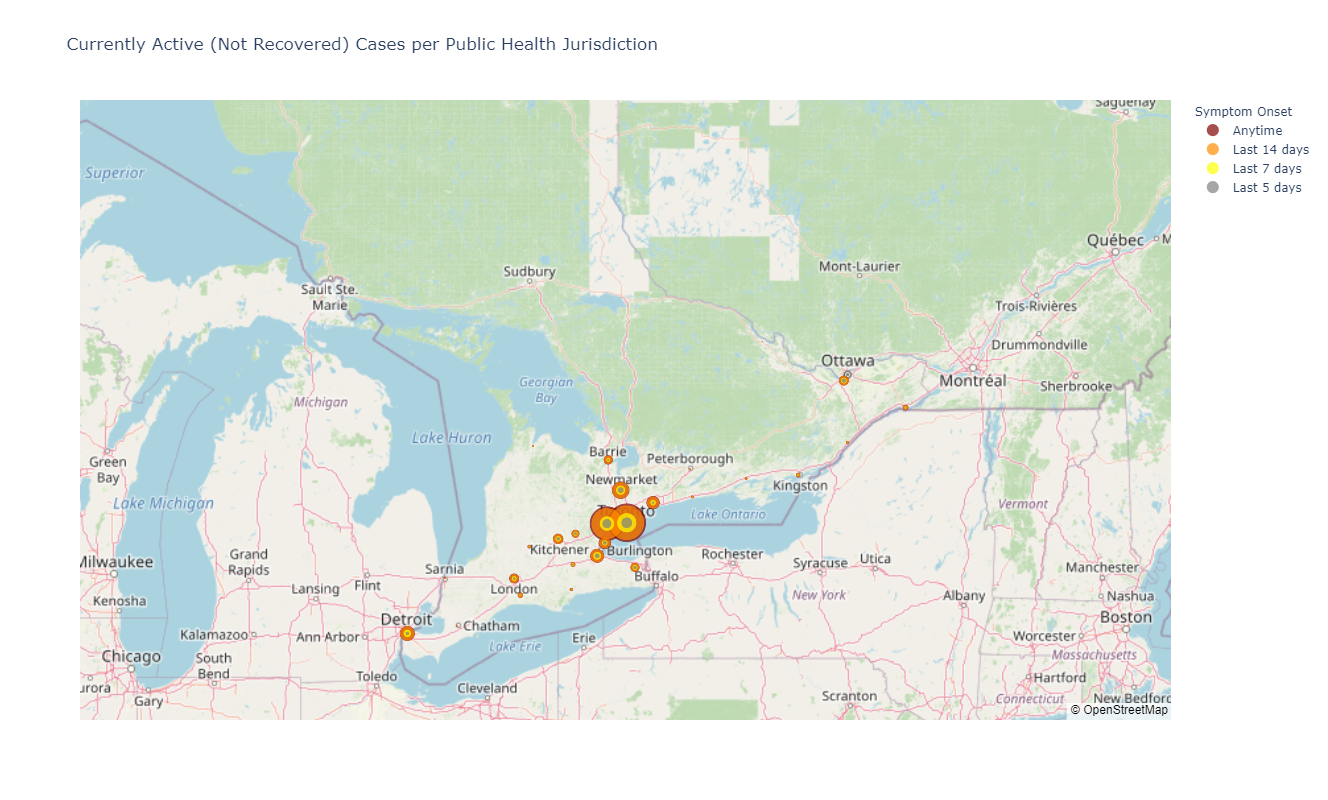

In [47]:
#hide_input
activemap = px.scatter_mapbox(df_active, 
                              lat="Latitude", 
                              lon="Longitude",  
                              color="Symptom_Onset", 
                              color_discrete_sequence=["maroon", "darkorange", "yellow", "grey"], 
                              size="Cases",
                              hover_name="Reporting_PHU", 
                              size_max=28, 
                              zoom=5.4,
                              center=dict(lat=45, lon=-79.4), 
                              height=800, 
                              #width=900,
                              labels={"Symptom_Onset" : "Symptom Onset"},
                              # tracking  currently active cases based on PHU
                              title="Currently Active (Not Recovered) Cases per Public Health Jurisdiction"
                              )
activemap.update_layout(mapbox_style="open-street-map")
#activemap.show()
#HTML(activemap.to_html())

In [48]:
#hide
# analyze_report = sv.analyze(src)
# analyze_report.show_html('report.html', open_browser=False)
# import IPython
# IPython.display.HTML('report.html')

In [49]:
#hide
src_testing.tail()

,Reported Date,Confirmed Negative,Presumptive Negative,Presumptive Positive,Confirmed Positive,Resolved,Deaths,Total Cases,Total patients approved for testing as of Reporting Date,Total tests completed in the last day,Percent positive tests in last day,Under Investigation,Number of patients hospitalized with COVID-19,Number of patients in ICU with COVID-19,Number of patients in ICU on a ventilator with COVID-19,Total Positive LTC Resident Cases,Total Positive LTC HCW Cases,Total LTC Resident Deaths,Total LTC HCW Deaths
311,2020-12-13,NaN,NaN,NaN,16204.0,120028.0,3949.0,140181.0,6962643.0,58190.0,3.2,51051,813.0,253.0,142.0,9279.0,3663.0,2479.0,8.0
312,2020-12-14,NaN,NaN,NaN,16586.0,121563.0,3972.0,142121.0,7019734.0,57091.0,4.6,32045,857.0,244.0,149.0,9358.0,3678.0,2490.0,8.0
313,2020-12-15,NaN,NaN,NaN,17031.0,123373.0,3992.0,144396.0,7059300.0,39566.0,5.4,45770,921.0,249.0,156.0,9378.0,3686.0,2491.0,8.0
314,2020-12-16,NaN,NaN,NaN,17084.0,125416.0,4035.0,146535.0,7108489.0,49189.0,5.1,65597,932.0,256.0,157.0,9462.0,3717.0,2513.0,8.0
315,2020-12-17,NaN,NaN,NaN,17484.0,127425.0,4058.0,148967.0,7166667.0,58178.0,4.0,78631,919.0,263.0,172.0,9538.0,3750.0,2526.0,8.0


In [50]:
#hide

df_testing = src_testing.drop(['Confirmed Negative',	'Presumptive Negative',	'Presumptive Positive',
                  'Total patients approved for testing as of Reporting Date',
                  'Under Investigation'], axis=1).fillna(0)

df_testing['New Cases'] = df_testing['Total Cases'].fillna(0).diff()
df_testing['New Deaths'] = df_testing['Deaths'].fillna(0).diff()
df_testing['Completed Tests Cumulative'] = df_testing['Total tests completed in the last day'].cumsum()

# rolling averages
numdays = 7

df_testing['New Cases 5 Day Average'] = round(df_testing['New Cases'].rolling(5).mean())
df_testing['New Cases 7 Day Average'] = round(df_testing['New Cases'].rolling(numdays).mean())
df_testing['New Tests 7 Day Average'] = round(df_testing['Total tests completed in the last day'].rolling(numdays).mean())

df_testing['7 Day Avg Percent Positivity'] = round((df_testing['New Cases 7 Day Average'] / df_testing['New Tests 7 Day Average']) *100, 2)

df_testing

,Reported Date,Confirmed Positive,Resolved,Deaths,Total Cases,Total tests completed in the last day,Percent positive tests in last day,Number of patients hospitalized with COVID-19,Number of patients in ICU with COVID-19,Number of patients in ICU on a ventilator with COVID-19,...,Total Positive LTC HCW Cases,Total LTC Resident Deaths,Total LTC HCW Deaths,New Cases,New Deaths,Completed Tests Cumulative,New Cases 5 Day Average,New Cases 7 Day Average,New Tests 7 Day Average,7 Day Avg Percent Positivity
0,2020-01-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN
1,2020-01-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2,2020-01-28,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN
3,2020-01-30,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN
4,2020-01-31,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311,2020-12-13,16204.0,120028.0,3949.0,140181.0,58190.0,3.2,813.0,253.0,142.0,...,3663.0,2479.0,8.0,1677.0,16.0,6849561.0,1854.0,1839.0,54477.0,3.38
312,2020-12-14,16586.0,121563.0,3972.0,142121.0,57091.0,4.6,857.0,244.0,149.0,...,3678.0,2490.0,8.0,1940.0,23.0,6906652.0,1864.0,1841.0,56164.0,3.28
313,2020-12-15,17031.0,123373.0,3992.0,144396.0,39566.0,5.4,921.0,249.0,156.0,...,3686.0,2491.0,8.0,2275.0,20.0,6946218.0,1923.0,1927.0,56216.0,3.43
314,2020-12-16,17084.0,125416.0,4035.0,146535.0,49189.0,5.1,932.0,256.0,157.0,...,3717.0,2513.0,8.0,2139.0,43.0,6995407.0,1981.0,1962.0,56308.0,3.48


# Timeline of Cases

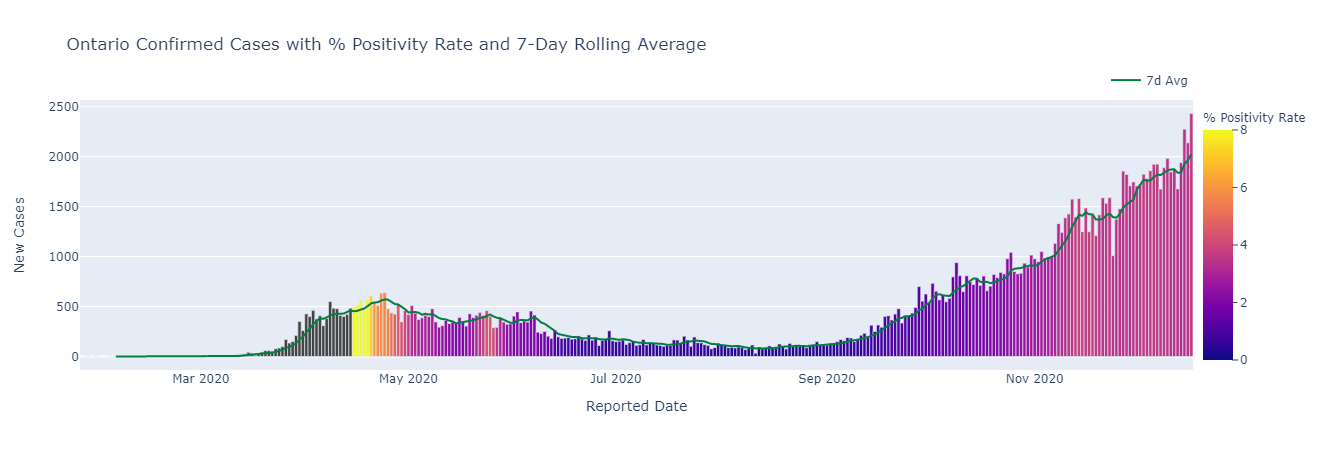

In [51]:
#hide_input

# report daily case load and % positivity

fig_conf = px.bar(df_testing,
              x='Reported Date',
              y='New Cases',
              color='7 Day Avg Percent Positivity', range_color=[0,8],
              title='Ontario Confirmed Cases with % Positivity Rate and 7-Day Rolling Average',
              labels={'7 Day Avg Percent Positivity': '% Positivity Rate'}
              )
fig_conf.update_layout(bargap=0)

fig_conf.update_layout(coloraxis_colorbar=dict(yanchor="top", y=1, x=1,
                                          ticks="outside",
                                          ticksuffix=""))

fig_conf.add_trace(go.Scatter(
    x=df_testing['Reported Date'],
    y=df_testing['New Cases 7 Day Average'],
    mode='lines',
    name='7d Avg',
    line=dict(color="#057D41", dash="solid")
    ))

fig_conf.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1,))

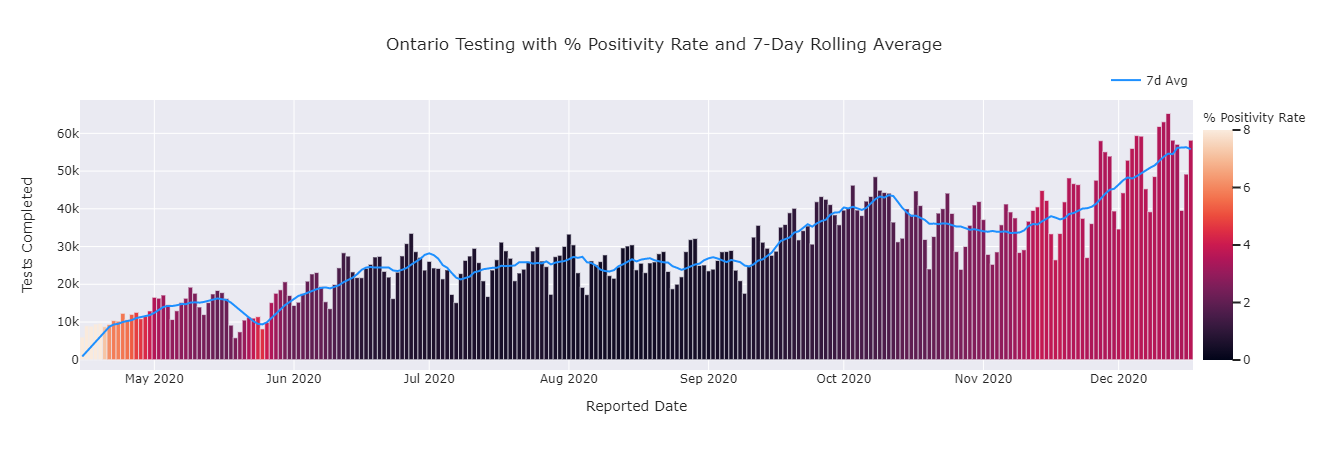

In [52]:
#hide_input

# report tests completed

# testing data does not exist prior to April 15, 2020
df_test = df_testing[(df_testing["Total tests completed in the last day"].notnull()) & (df_testing["Total tests completed in the last day"] != 0)]

fig_test = px.bar(df_test,
              x='Reported Date',
              y='Total tests completed in the last day',
              template='seaborn',
              color='7 Day Avg Percent Positivity', range_color=[0,8],
              title='Ontario Testing with % Positivity Rate and 7-Day Rolling Average',
              labels={'7 Day Avg Percent Positivity': '% Positivity Rate',
                      'Total tests completed in the last day': 'Tests Completed'},
 )           
fig_test.update_layout(bargap=0)

fig_test.update_layout(coloraxis_colorbar=dict(yanchor="top", y=1, x=1,
                                          ticks="outside",
                                          ticksuffix=""))

fig_test.add_trace(go.Scatter(
    x=df_test['Reported Date'],
    y=df_test['New Tests 7 Day Average'],
    mode='lines',
    name='7d Avg',
    line=dict(color="#1E90FF", dash="solid")
    ))

fig_test.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1,))

In [53]:
#hide_input
display(HTML("<div style='text-Align: right; margin-right: 10%;'> <span style='text-align: right'> **Note that testing data is not available prior to April 15, 2020. </span> </div>"))

## Infection Rate Compared to Notable Public Events & Announcements

In [54]:
#hide

# todo: webscrape Canadian website for holidays and dates for automation

public_events = [
{"name": "Easter Weekend", "date": "2020-04-10"},
{"name": "Mother's Day", "date": "2020-05-10", "ay" : 60},
{"name": "Victoria Day", "date": "2020-05-18"},
{"name": "Trinity Bellwoods<br>Park Weekend", "date": "2020-05-23", "ay": -100, "ax": 80},
{"name": "Father's Day", "date": "2020-06-21", "ay": 40},
{"name": "Canada Day", "date": "2020-07-01"},
{"name": "Civic Holiday", "date": "2020-08-03"},
{"name": "Schools reopen<br>for 2020-21", "date": "2020-09-08"},
{"name": "Thanksgiving<br>Weekend", "date": "2020-10-12", "ax": -40, "ay": -50},
{"name": "Halloween", "date": "2020-10-31", "ax": -20},
{"name": "Diwali", "date": "2020-11-14", "ax": -60, "ay": -25},
{"name": "Black Friday", "date": "2020-11-27", "ax": -20},
{"name": "Vaccine Rollout", "date": "2020-12-15"}
# {"name": "Christmas", "date": "2020-12-25"},
# {"name": "Boxing Week<br> begins", "date": "2020-12-26"},
# {"name": "New Year's Day", "date": "2021-01-01"},
]

government_events = [
{"name": "Ontario Lockdown #1", "date": "2020-03-23","ax": -20, "ay": -80},
#{"name": "Some regions enter stage 2", "date": "2020-06-08"},
{"name": "Ontario in Stage 2", "date": "2020-06-24", "ay": -40},
{"name": "Ontario in Stage 3", "date": "2020-07-31", "ay": -30},
{"name": "Schools reopen<br>for 2020-21", "date": "2020-09-08", "ax": -40, "ay": -80},
{"name": "Second Wave confirmed", "date": "2020-09-28", "ax": -40, "ay": -80},
{"name": "Peel/Toronto/Ottawa<br>revert to<br>modified Stage 2", "date": "2020-10-12","ax":30, "ay": 100},
{"name": "Peel/Ottawa<br>in Orange Zone", "date": "2020-11-07","ax": 25, "ay": 60},
{"name": "Peel/Toronto<br>in Red Zone", "date": "2020-11-12", "ax": -80, "ay": -30},
{"name": "Halton in Red Zone", "date": "2020-11-16", "ax": -50},
{"name": "Peel/Toronto in<br>Lockdown<br>#2", "date": "2020-11-23", "ay": -80},
{"name": "York/Windsor<br>in Lockdown<br>#2", "date": "2020-12-14", "ay": 80},
{"name": "Vaccine Rollout", "date": "2020-12-15"}          
]

other_events = [
{"name": "GoodLife email request to lobby MPPs", "date": "2020-10-28"},          
]

# Sources:
# https://www.peelschools.org/schools/reopening/Pages/default.aspx
# https://globalnews.ca/news/6859636/ontario-coronavirus-timeline/

In [55]:
#hide

# append events to an annotation dictionary

public_dates_annot = []

for event in public_events:
      if event["date"]:
        ax = event.get("ax")
        if ax is None:
            ax = 0
        ay = event.get("ay")
        if ay is None:
            ay = -60
        public_dates_annot.append(dict(
                  x=event["date"],
                  y=df_testing[df_testing["Reported Date"] == event["date"]]["New Cases 5 Day Average"].values[0],
                  xref="x",
                  yref="y",
                  text=event["name"],
                  showarrow=True,
                  arrowhead=3,
                  ax=ax,
                  ay=ay
        ))

government_dates_annot = []

for event in government_events:
      if event["date"]:
        ax = event.get("ax")
        if ax is None:
            ax = 0
        ay = event.get("ay")
        if ay is None:
            ay = -60
        government_dates_annot.append(dict(
                  x=event["date"],
                  y=df_testing[df_testing["Reported Date"] == event["date"]]["New Cases 5 Day Average"].values[0],
                  xref="x",
                  yref="y",
                  text=event["name"],
                  showarrow=True,
                  arrowhead=3,
                  ax=ax,
                  ay=ay
        ))

government_dates_annot[0]

{'x': '2020-03-23',
 'y': 58.0,
 'xref': 'x',
 'yref': 'y',
 'text': 'Ontario Lockdown #1',
 'showarrow': True,
 'arrowhead': 3,
 'ax': -20,
 'ay': -80}

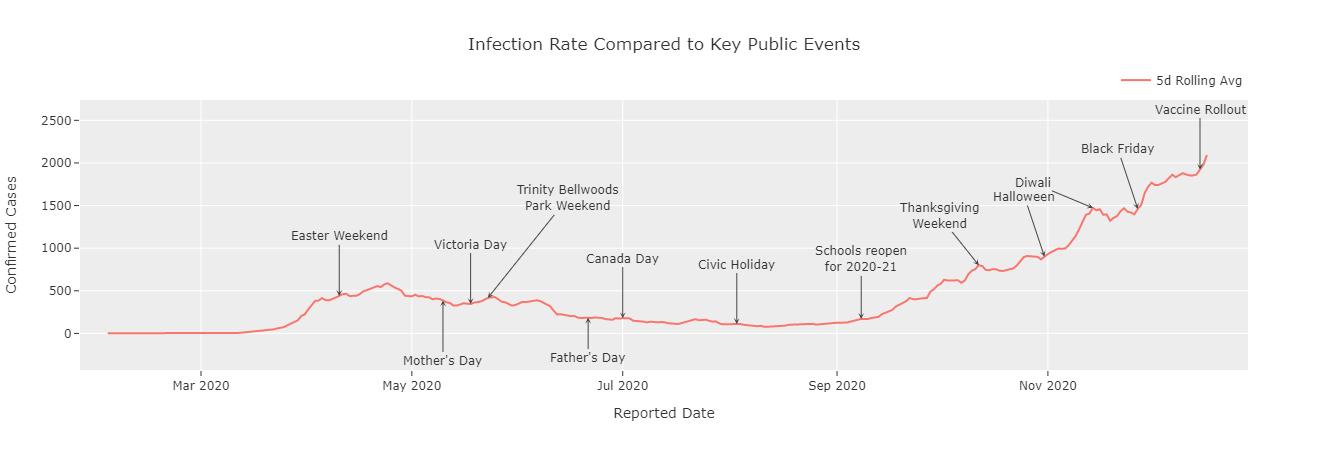

In [56]:
#hide_input

fig_public = go.Figure()
fig_public.add_trace(go.Scatter(x=df_testing['Reported Date'],
                               y=df_testing['New Cases 5 Day Average'],
                               mode="lines",
                               #line=dict(color="maroon", dash="dot"),
                               name='5d Rolling Avg',
                               showlegend=True
))

fig_public.update_layout(annotations=public_dates_annot,
                        title="Infection Rate Compared to Key Public Events",
                        template='ggplot2',
                        width=1000,
                        xaxis_title="Reported Date",
                        yaxis_title="Confirmed Cases")

fig_public.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1,))

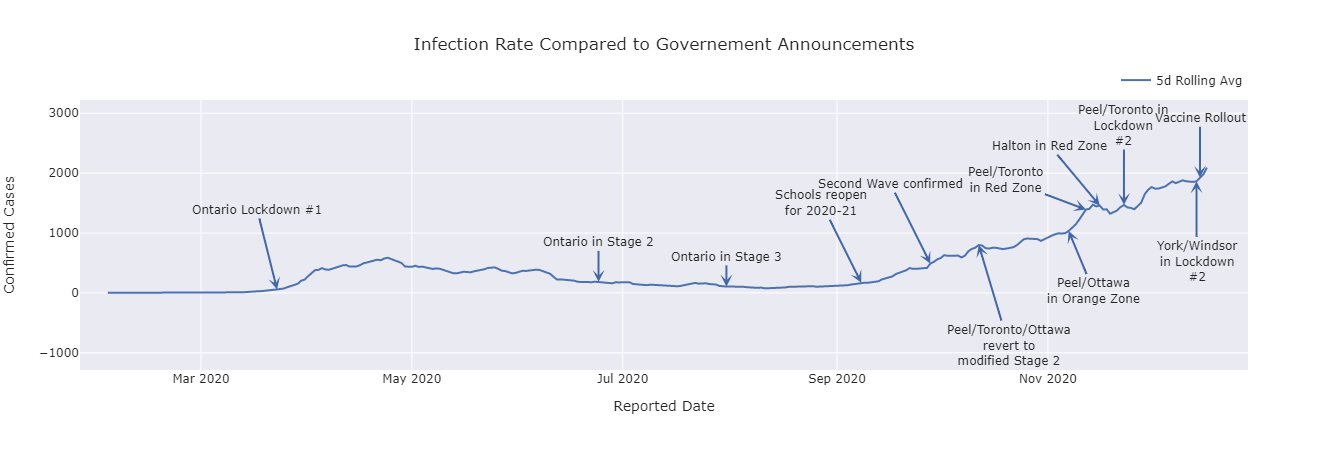

In [57]:
#hide_input

fig_gov = go.Figure()
fig_gov.add_trace(go.Scatter(x=df_testing['Reported Date'],
                             y=df_testing['New Cases 5 Day Average'],
                             mode="lines",
                             #line=dict(color="blue", dash="dot"),
                             showlegend=True,
                             name='5d Rolling Avg',
 
))

fig_gov.update_layout(annotations=government_dates_annot,
                        title="Infection Rate Compared to Governement Announcements",
                        template='seaborn',
                        width=1000,
                        xaxis_title="Reported Date",
                        yaxis_title="Confirmed Cases",)

fig_gov.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1,))

# Deaths

## Overview of Fatalities by Age Group

In [58]:
#hide_input

df_deaths = src_conpos[src_conpos['Outcome1'] == 'Fatal'].groupby(['Age_Group']).count()["Row_ID"] \
.reset_index().iloc[:,[0,1]].rename(columns={'Row_ID': 'Deaths'})

df_res = src_conpos[src_conpos['Outcome1'] == 'Resolved'].groupby(['Age_Group']).count()["Row_ID"] \
.reset_index().iloc[:,[0,1]].rename(columns={'Row_ID': 'Resolved'})

df_nres = src_conpos[src_conpos['Outcome1'] == 'Not Resolved'].groupby(['Age_Group']).count()["Row_ID"] \
.reset_index().iloc[:,[0,1]].rename(columns={'Row_ID': 'Not Resolved'})

# merge dataframes together and clean up

df_age = df_deaths.merge(df_res, on='Age_Group').merge(df_nres, on='Age_Group').replace('<20', '0-19') \
.rename(columns={'Age_Group': 'Age Group'}).sort_values('Age Group')

del [df_deaths, df_res, df_nres]

# include percentages
df_age['Death Rate'] = (df_age['Deaths'] / (df_age['Resolved'] + df_age['Not Resolved']))
df_age['Survival Rate'] = (1 - df_age['Death Rate'])

x = df_age \
.drop(columns=['Resolved', 'Not Resolved']) \
.style.format({"Death Rate": "{:.2%}",
                     "Survival Rate": "{:.2%}"}) \
                     .background_gradient(cmap='Reds', subset=['Deaths', 'Death Rate']) \
                     .background_gradient(cmap='Greens', subset=['Survival Rate']) \
                     .hide_index()

x.set_properties(**{'text-align': 'center'}).hide_index()

Age Group,Deaths,Death Rate,Survival Rate
0-19,1,0.01%,99.99%
20s,5,0.02%,99.98%
30s,10,0.04%,99.96%
40s,32,0.15%,99.85%
50s,130,0.61%,99.39%
60s,354,2.61%,97.39%
70s,705,10.40%,89.60%
80s,1489,27.26%,72.74%
90s,1332,42.09%,57.91%


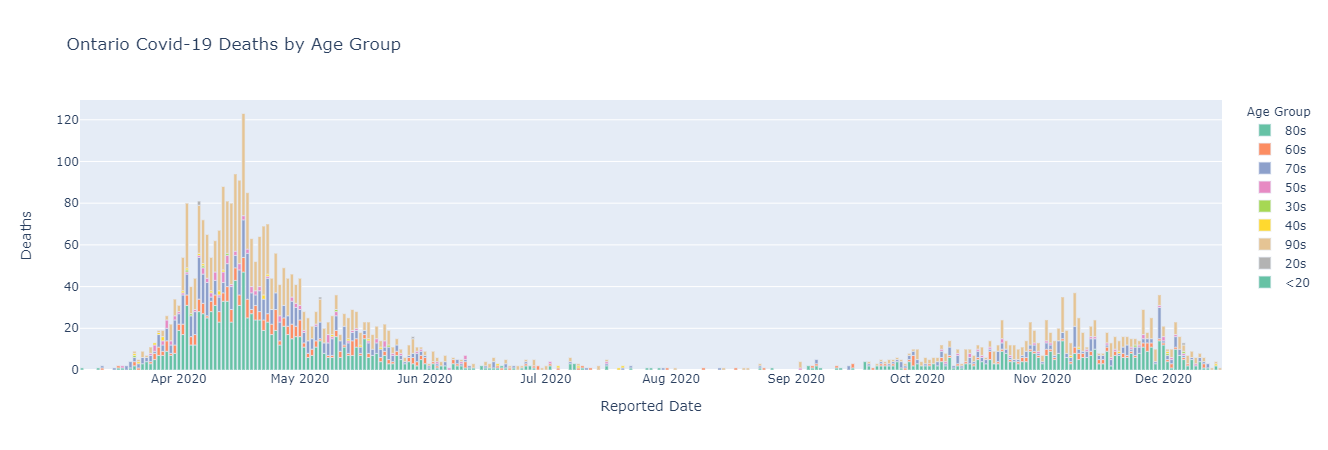

In [59]:
#hide_input

df_deathts = src_conpos[src_conpos['Outcome1'] == 'Fatal'].groupby(['Case_Reported_Date', 'Age_Group']).count()['Row_ID'] \
.reset_index().rename(columns={"Row_ID": "Cases"})

fig_deaths = px.bar(df_deathts,
                    y='Cases',
                    x='Case_Reported_Date',
                    color='Age_Group',
                    labels={"Case_Reported_Date" : "Reported Date", "Age_Group" : "Age Group", "Cases" : "Deaths"},
                    color_discrete_sequence=px.colors.qualitative.Set2,
                    title = "Ontario Covid-19 Deaths by Age Group"
)

fig_deaths.show()

In [60]:
#hide

def acquisition(acq):
    if acq == 'CC':
        return 'Close Contact'
    elif acq == 'OB':
        return 'Institutional Outbreak'
    elif acq == 'No known epi link':
        return 'Community Spread'
    else:
        return acq

df_cases = src_conpos.groupby(['Reporting_PHU', 'Case_AcquisitionInfo']).count()['Row_ID'].reset_index() \
    .rename(columns={'Row_ID': 'Cases'})

# df_cases['Acquisition'] = df_cases['Case_AcquisitionInfo'].apply(aquisition)

df_cases['Acquisition'] = df_cases.apply(lambda x: acquisition(x['Case_AcquisitionInfo']), axis=1)

df_phucount = src_conpos.groupby(['Reporting_PHU']).count()['Row_ID'].reset_index().rename(columns={'Row_ID': 'Total'})

df_cases = pd.merge(df_cases, df_phucount, how='left', on='Reporting_PHU')

df_cases['Reporting_PHU'] = df_cases['Reporting_PHU'].str.replace(' Public Health', '').str.replace(' Health Unit', '') \
    .str.replace(' Unit', '').str.replace(',', '')

df_cases = df_cases.sort_values(['Total', 'Acquisition'], ascending=[True, True]).reset_index(drop=True)

df_cases.head()

,Reporting_PHU,Case_AcquisitionInfo,Cases,Acquisition,Total
0,Timiskaming,CC,13,Close Contact,28
1,Timiskaming,OB,8,Institutional Outbreak,28
2,Timiskaming,MISSING INFORMATION,1,MISSING INFORMATION,28
3,Timiskaming,NO KNOWN EPI LINK,6,NO KNOWN EPI LINK,28
4,Algoma,CC,20,Close Contact,62


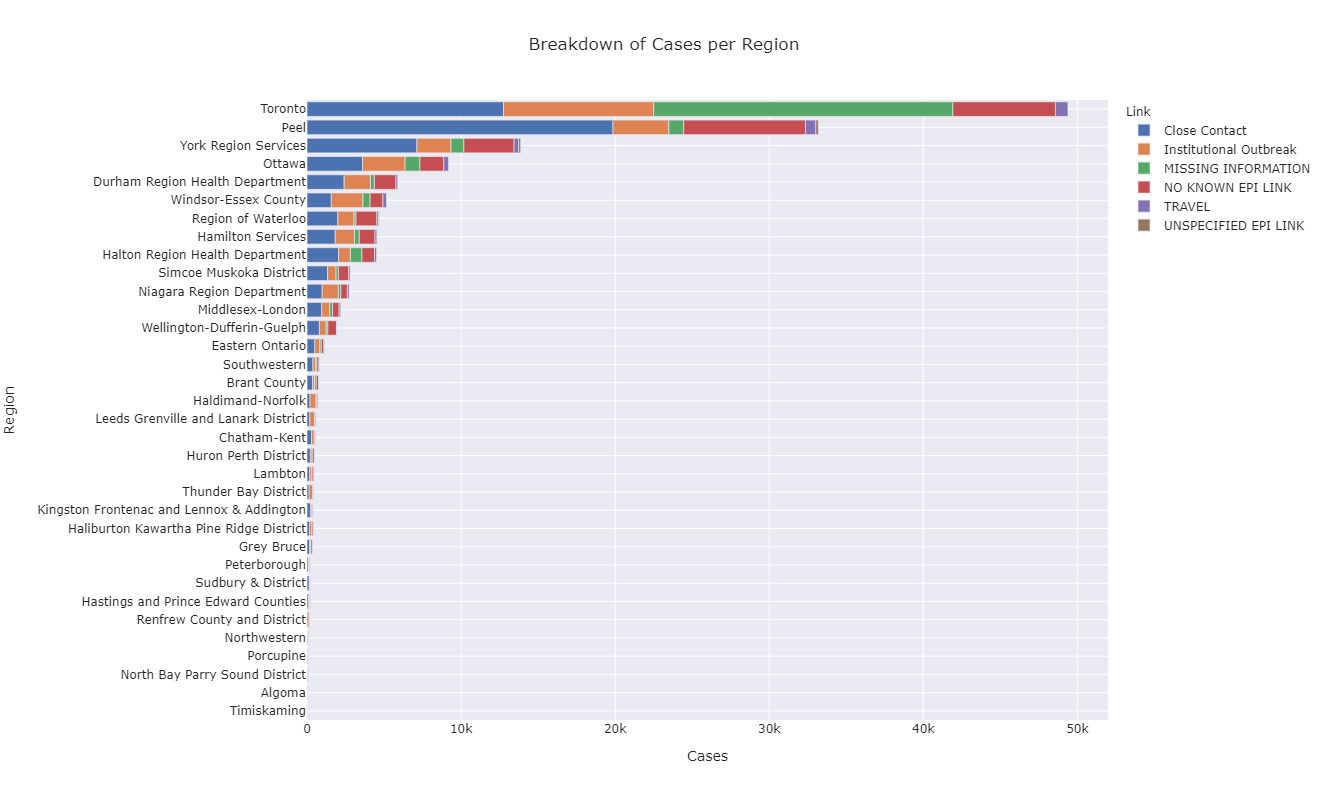

In [61]:
#hide_input

fig_phucases = px.bar(df_cases,
y='Reporting_PHU',
x='Cases',
color='Acquisition',
orientation='h',
#color_discrete_sequence=px.colors.qualitative.Vivid,
height=800,
title='Breakdown of Cases per Region',
labels={"Total" : "Confirmed Cases", "Reporting_PHU" : "Region", "Acquisition": "Link"},
template='seaborn'
)

fig_phucases.show()

In [62]:
#hide
src_conpos.groupby(['Case_Reported_Date', 'Reporting_PHU', 'Outcome1']).count()['Row_ID'].reset_index().rename(columns={'Row_ID': 'Cases'})

,Case_Reported_Date,Reporting_PHU,Outcome1,Cases
0,2020-01-23,Toronto Public Health,Resolved,2
1,2020-01-24,Middlesex-London Health Unit,Resolved,1
2,2020-02-21,Toronto Public Health,Resolved,1
3,2020-02-25,Toronto Public Health,Resolved,1
4,2020-02-26,Toronto Public Health,Resolved,1
...,...,...,...,...
7420,2020-12-16,Toronto Public Health,Not Resolved,119
7421,2020-12-16,Toronto Public Health,Resolved,3
7422,2020-12-16,Wellington-Dufferin-Guelph Public Health,Not Resolved,24
7423,2020-12-16,Windsor-Essex County Health Unit,Not Resolved,72


In [63]:
#hide

df_phu = src_daily.drop(columns=['Total']).melt(id_vars='Date', value_name='Confirmed') \
.rename(columns={"variable" : "Public_Health_Unit"}) \
.fillna(0).sort_values(['Date']).reset_index(drop=True)

df_phu.head()

,Date,Public_Health_Unit,Confirmed
0,2020-03-24,Algoma_Public_Health_Unit,0.0
1,2020-03-24,Chatham-Kent_Health_Unit,0.0
2,2020-03-24,Durham_Region_Health_Department,0.0
3,2020-03-24,Thunder_Bay_District_Health_Unit,0.0
4,2020-03-24,Eastern_Ontario_Health_Unit,0.0


In [64]:
#hide

df_phu[df_phu['Date'] == df_phu['Date'].max()].sort_values(['Public_Health_Unit']).sort_values('Confirmed', ascending=False).reset_index(drop=True).head(10)

,Date,Public_Health_Unit,Confirmed
0,2020-12-17,Toronto_Public_Health,737.0
1,2020-12-17,Peel_Public_Health,434.0
2,2020-12-17,York_Region_Public_Health_Services,209.0
3,2020-12-17,Windsor-Essex_County_Health_Unit,190.0
4,2020-12-17,Hamilton_Public_Health_Services,142.0
5,2020-12-17,Halton_Region_Health_Department,104.0
6,2020-12-17,"Region_of_Waterloo,_Public_Health",77.0
7,2020-12-17,Durham_Region_Health_Department,73.0
8,2020-12-17,Ottawa_Public_Health,70.0
9,2020-12-17,Wellington-Dufferin-Guelph_Public_Health,65.0


In [65]:
#hide

import warnings
warnings.filterwarnings("ignore")

ontario = df_phu.groupby(['Date'])['Confirmed'].sum().reset_index()
toronto = df_phu[df_phu['Public_Health_Unit'].isin(['Toronto_Public_Health'])]
peel = df_phu[df_phu['Public_Health_Unit'].isin(['Peel_Public_Health'])]
york = df_phu[df_phu['Public_Health_Unit'].isin(['York_Region_Public_Health_Services'])]
halton = df_phu[df_phu['Public_Health_Unit'].isin(['Halton_Region_Health_Department'])]

toronto['Rolling 7d'] = toronto['Confirmed'].rolling(7).mean()
peel['Rolling 7d'] = peel['Confirmed'].rolling(7).mean()
york['Rolling 7d'] = york['Confirmed'].rolling(7).mean()
halton['Rolling 7d'] = halton['Confirmed'].rolling(7).mean()
ontario['Rolling 7d'] = ontario['Confirmed'].rolling(7).mean()

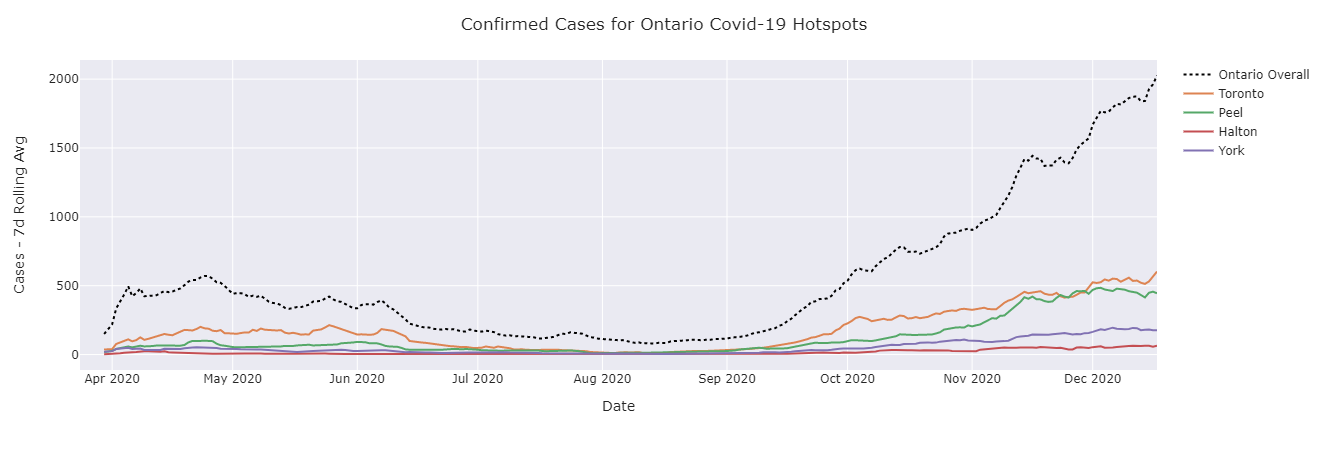

In [66]:
#hide_input

fig_hot = px.line(width=1000, template='seaborn'
                  )

fig_hot.add_trace(go.Scatter(
    x=ontario['Date'],
    y=ontario['Rolling 7d'],
    mode='lines',
    name='Ontario Overall',
    line=dict(color="black", dash="dot")
    ))
fig_hot.add_trace(go.Scatter(
    x=toronto['Date'],
    y=toronto['Rolling 7d'],
    mode='lines',
    name='Toronto',
    #line=dict(color="yellow", dash="solid")
    ))

fig_hot.add_trace(go.Scatter(
    x=peel['Date'],
    y=peel['Rolling 7d'],
    mode='lines',
    name='Peel',
    #line=dict(color="red", dash="solid")
    ))
fig_hot.add_trace(go.Scatter(
    x=halton['Date'],
    y=halton['Rolling 7d'],
    mode='lines',
    name='Halton',
    #line=dict(color="orange", dash="solid")
    ))
fig_hot.add_trace(go.Scatter(
    x=york['Date'],
    y=york['Rolling 7d'],
    mode='lines',
    name='York',
    #line=dict(color="green", dash="solid")
    ))

fig_hot.update_layout(title='Confirmed Cases for Ontario Covid-19 Hotspots',
                      xaxis_title='Date',
                      yaxis_title='Cases - 7d Rolling Avg')